<h2>Step 1: Load Dataset</h2>

In [1]:
#load important libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load dataset from NumPy array files
X_train = np.load('./Dataset/X_train.npy')
Y_train = np.load('./Dataset/Y_train.npy')
X_test = np.load('./Dataset/X_test.npy')
Y_test = np.load('./Dataset/Y_test.npy')

In [3]:
#determine shapes of loaded arrays
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((57266, 28, 28), (57266,), (3015, 28, 28), (3015,))

In [4]:
#select random image array index to show
train_index = 1185               # should be < 57266
test_index = 1011                # should be < 3015

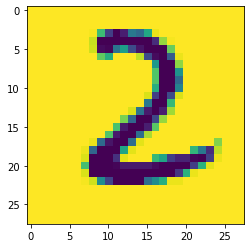

2.0

In [5]:
#show training image & label for given train_index
plt.imshow(X_train[train_index], interpolation='nearest')
plt.show()
Y_train[train_index]

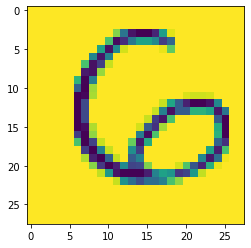

6.0

In [6]:
#show test image & label for given test_index
plt.imshow(X_test[test_index], interpolation='nearest')
plt.show()
Y_test[test_index]

<h2>Step 2: Create convolutional Layer</h2>

In [7]:
def convolutionLayer(image, imageFilters, stride=[1,1]):
    
    #assume 'valid' padding
    padding = 0
        
    #get dimensions of image
    heightImage = image.shape[0]
    widthImage = image.shape[1]
    channelImage = 1
    if(len(image.shape)>2):
        channelImage = image.shape[2]
        
    #get dimensions of imageFilters
    numberImageFilters = imageFilters.shape[0]
    heightImageFilters = imageFilters.shape[1]
    widthImageFilters = imageFilters.shape[2]
    channelImageFilters = 1
    if(len(imageFilters.shape)>3):
        channelImageFilters = imageFilters.shape[3]

    #check if (No. of channels in image == imageFilters depth) && (imageFilters.length == imageFilters.breadth)
    if( (channelImage == channelImageFilters) and (heightImageFilters==widthImageFilters) ):
        #init output
        heightOutputImage = int((heightImage+2*padding-heightImageFilters)/stride[0] + 1)
        widthOutputImage = int((widthImage+2*padding-widthImageFilters)/stride[1] + 1)
        results = np.zeros([numberImageFilters, heightOutputImage, widthOutputImage], dtype=float)
        
        #iterate through all possible locations where filter can be placed
        #create temp variable to store row_count in results
        iprime = 0
        for i in range(0, heightImage-heightImageFilters+1, stride[0]):
            #create temp variable to store col_count in results
            jprime = 0    
            for j in range(0, widthImage-widthImageFilters+1, stride[1]):
                #iterate through each filter
                for k in range(numberImageFilters):
                    currentImageFilter = imageFilters[k, :]
                    #get sum of (elementwise product of image and currentImageFilter at current location)
                    if (channelImage == 1):
                        results[k][iprime][jprime] = np.sum(np.multiply(image[i:i+heightImageFilters, j:j+widthImageFilters], currentImageFilter))
                    
                    else:
                        results[k][iprime][jprime] = np.sum(np.multiply(image[i:i+heightImageFilters, j:j+widthImageFilters, :], currentImageFilter))
                #increment temp col_count
                jprime = jprime + 1
            #increment temp row_count
            iprime = iprime + 1
        return results  

In [8]:
#create temporary imageFilter for demo
imageFilters = np.array([
    [[[1,1,1],[0,0,0],[-1,-1,-1]],
     [[1,1,1],[0,0,0],[-1,-1,-1]],
     [[1,1,1],[0,0,0],[-1,-1,-1]]],
    [[[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]],
     [[0,0,0],[0,0,0],[0,0,0]],
     [[1,1,1],[1,1,1],[1,1,1]]]
    ])
print(imageFilters.shape)

(2, 3, 3, 3)


In [9]:
#create temporary image for demo
image = np.array(
    [[[1,1,1],[2,2,2],[3,3,3],[4,4,4]],
     [[5,5,5],[6,6,6],[7,7,7],[8,8,8]],
     [[9,9,9],[10,10,10],[11,11,11],[12,12,12]],
     [[13,13,13],[14,14,14],[15,15,15],[16,16,16]]])
print(image.shape)

(4, 4, 3)


In [10]:
#run demo to show function is working
convolutionLayer(image,imageFilters,[2,2])

array([[[-18.]],

       [[ 72.]]])

<h2>Step 3: Create Max Pooling Layer </h2>

In [11]:
def maxPoolingLayer(image, size=[2,2], stride=[2,2]):
    
        #get dimensions of image
        heightImage = image.shape[0]
        widthImage = image.shape[1]
        
        #init output
        heightOutputImage = int((image.shape[0]-size[0])/stride[0]+1)
        widthOutputImage = int((image.shape[1]-size[1])/stride[1]+1)
        channelOutputImage = image.shape[-1]
        results = np.zeros([heightOutputImage, widthOutputImage, channelOutputImage], dtype=float)
        #do for each map(channel) in image
        for channel in range(channelOutputImage):
            #create temp variable to store row_count in results
            iprime = 0
            #do for each row in stride[0] steps
            for i in range(0, heightImage-size[0]+1, stride[0]):
                #create temp variable to store col_count in results
                jprime = 0
                #do for each col in in stride[1] steps
                for j in range(0, widthImage-size[1]+1, stride[1]):
                    results[iprime, jprime, channel] = np.max(image[i:i+size[0], j:j+size[1], channel])
                    #increment temp col_count
                    jprime = jprime + 1
                #increment temp row_count
                iprime = iprime + 1
                
        return results

In [12]:
#run demo to show function is working
maxPoolingLayer(image)

array([[[ 6.,  6.,  6.],
        [ 8.,  8.,  8.]],

       [[14., 14., 14.],
        [16., 16., 16.]]])